In [1]:
pip install bs4

  Preparing metadata (setup.py) ... done
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1256 sha256=042e1285a3f3b667c5bd5009a661d6115b96cff459867e5b616e6189d943123e
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
Successfully built bs4


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
import pandas as pd
import re
import glob
import os
import numpy as np

def smi_to_df(file_path):
    file = open(file_path, 'r', encoding='cp949')
    wholefile = file.readlines()
    pattern = re.compile(r'<SYNC Start=(\d+)><P Class=KRCC>\n(.*?)\n', re.DOTALL)
    matches = pattern.findall(''.join(wholefile))
    df = pd.DataFrame(matches, columns=['Time_Stamp(s)', 'Text'])
    df['Time_Stamp(s)'] = df['Time_Stamp(s)'].astype(float) / 1000
    return df

def convert_to_percentage(df):
    start_timestamp = df['Time_Stamp(s)'].min()
    end_timestamp = df['Time_Stamp(s)'].max()
    df['Scaled_Percent'] = (df['Time_Stamp(s)'] - start_timestamp) / (end_timestamp - start_timestamp) * 100
    return df

def calculate_speed(df):
    df['Time_difference'] = df['Time_Stamp(s)'].shift(-1) - df['Time_Stamp(s)']
    df['Time_difference'].fillna(0, inplace=True)
    df['words'] = df['Text'].apply(lambda x: len(x))
    df = df[(df['Time_difference'] < 20) & (df['Time_difference'] > 1) & (df['words'] > 10)]
    df['speed'] = df['Time_difference'] / df['words']
    return df

def get_average_speed_by_percent(df):
    avg_speed_by_percent = df.groupby('Scaled_Percent')['speed'].mean().reset_index()
    return avg_speed_by_percent

def calculate_interval_speed(df, interval):
    interval_speeds = []
    for i in range(0, 100, interval):
        subset_df = df[(df['Scaled_Percent'] >= i) & (df['Scaled_Percent'] < i + interval)]
        median_speed = np.nanmedian(subset_df['speed'])  # 중앙값으로 변경
        interval_speeds.append(median_speed)
    return interval_speeds


def main():
    smi_file_path = "/content/drive/MyDrive/인강프로젝트/EBS 스크립트 데이터/인기 강사/박자영/[2023 수능완성] 박자영 수학+확률과 통계(유형편)"
    smi_file_names = [os.path.join(smi_file_path, file) for file in os.listdir(smi_file_path) if file.endswith(".smi") and os.path.isfile(os.path.join(smi_file_path, file))]

    interval = 1  # 1% 간격으로 계산

    interval_speeds_list = []
    for file_path in smi_file_names:
       df = smi_to_df(file_path)
       df = convert_to_percentage(df)
       df = calculate_speed(df)
       avg_speed_by_percent = get_average_speed_by_percent(df)
       interval_speeds = calculate_interval_speed(avg_speed_by_percent, interval)
       interval_speeds_list.append(interval_speeds)

    combined_interval_speed_df = pd.DataFrame(interval_speeds_list).transpose()
    combined_interval_speed_df.index = range(1, 101)
    combined_interval_speed_df = combined_interval_speed_df.mean(axis=1)

    return combined_interval_speed_df  # 변수 반환

if __name__ == "__main__":
    combined_df_2 = main()  # 함수 실행 결과를 변수에 저장
    combined_df_2 = pd.DataFrame({'scale_percentage': combined_df_2.index, 'speed_median': combined_df_2.values})

    # 결과 데이터프레임 출력
    print(combined_df_2)


<ipython-input-30-e58c72277578>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['speed'] = df['Time_difference'] / df['words']
<ipython-input-30-e58c72277578>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['speed'] = df['Time_difference'] / df['words']
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
<ipython-input-30-e58c72277578>:27: SettingWithCopyWarning: 
A value is trying to b

    scale_percentage  speed_median
0                  1      0.132758
1                  2      0.127801
2                  3      0.125415
3                  4      0.129434
4                  5      0.129142
..               ...           ...
95                96      0.145013
96                97      0.137655
97                98      0.141332
98                99      0.137451
99               100      0.195115

[100 rows x 2 columns]


In [33]:
import pandas as pd
import re
import glob
import os
import numpy as np

def smi_to_df(file_path):
    file = open(file_path, 'r', encoding='cp949')
    wholefile = file.readlines()
    pattern = re.compile(r'<SYNC Start=(\d+)><P Class=KRCC>\n(.*?)\n', re.DOTALL)
    matches = pattern.findall(''.join(wholefile))
    df = pd.DataFrame(matches, columns=['Time_Stamp(s)', 'Text'])
    df['Time_Stamp(s)'] = df['Time_Stamp(s)'].astype(float) / 1000
    return df

def convert_to_percentage(df):
    start_timestamp = df['Time_Stamp(s)'].min()
    end_timestamp = df['Time_Stamp(s)'].max()
    df['Scaled_Percent'] = (df['Time_Stamp(s)'] - start_timestamp) / (end_timestamp - start_timestamp) * 100
    return df

def calculate_speed(df):
    df['Time_difference'] = df['Time_Stamp(s)'].shift(-1) - df['Time_Stamp(s)']
    df['Time_difference'].fillna(0, inplace=True)
    df['words'] = df['Text'].apply(lambda x: len(x))
    df = df[(df['Time_difference'] < 20) & (df['Time_difference'] > 1) & (df['words'] > 10)]
    df['speed'] = df['Time_difference'] / df['words']
    return df

def get_average_speed_by_percent(df):
    avg_speed_by_percent = df.groupby('Scaled_Percent')['speed'].mean().reset_index()
    return avg_speed_by_percent

def calculate_interval_speed(df, interval):
    interval_speeds = []
    for i in range(0, 100, interval):
        subset_df = df[(df['Scaled_Percent'] >= i) & (df['Scaled_Percent'] < i + interval)]
        median_speed = np.nanmedian(subset_df['speed'])  # 중앙값으로 변경
        interval_speeds.append(median_speed)
    return interval_speeds


def main():
    smi_file_path = "/content/drive/MyDrive/인강프로젝트/EBS 스크립트 데이터/비인기 강사/서영란/[수능 감(感) 잡기] 확률과 통계"
    smi_file_names = [os.path.join(smi_file_path, file) for file in os.listdir(smi_file_path) if file.endswith(".smi") and os.path.isfile(os.path.join(smi_file_path, file))]

    interval = 1  # 1% 간격으로 계산

    interval_speeds_list = []
    for file_path in smi_file_names:
       df = smi_to_df(file_path)
       df = convert_to_percentage(df)
       df = calculate_speed(df)
       avg_speed_by_percent = get_average_speed_by_percent(df)
       interval_speeds = calculate_interval_speed(avg_speed_by_percent, interval)
       interval_speeds_list.append(interval_speeds)

    combined_interval_speed_df = pd.DataFrame(interval_speeds_list).transpose()
    combined_interval_speed_df.index = range(1, 101)
    combined_interval_speed_df = combined_interval_speed_df.mean(axis=1)

    return combined_interval_speed_df  # 변수 반환

if __name__ == "__main__":
    combined_df_3 = main()  # 함수 실행 결과를 변수에 저장
    combined_df_3 = pd.DataFrame({'scale_percentage': combined_df_3.index, 'speed_median': combined_df_3.values})

    # 결과 데이터프레임 출력
    print(combined_df_3)


<ipython-input-33-9102d25abe9f>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['speed'] = df['Time_difference'] / df['words']
<ipython-input-33-9102d25abe9f>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['speed'] = df['Time_difference'] / df['words']
<ipython-input-33-9102d25abe9f>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

    scale_percentage  speed_median
0                  1      0.131815
1                  2      0.128762
2                  3      0.136969
3                  4      0.128335
4                  5      0.134623
..               ...           ...
95                96      0.135677
96                97      0.135397
97                98      0.137351
98                99      0.126460
99               100      0.127641

[100 rows x 2 columns]


In [32]:
import matplotlib.pyplot as plt
import koreanize_matplotlib

# 선 그래프 생성
plt.plot(combined_df_2.index, combined_df_2['speed_median'], label='인기강사')
plt.plot(combined_df_3.index, combined_df_3['speed_median'], label='비인기강사')

# 그래프 제목, 축 레이블, 범례 등 설정
plt.title('Comparison of Speed Averages')
plt.xlabel('Scale Percentage')
plt.ylabel('Speed Median')
plt.legend()

# 그래프 표시
plt.show()


KeyError: ignored

In [28]:
import pandas as pd
import re
import glob
import os
import numpy as np

def smi_to_df(file_path):
    file = open(file_path, 'r', encoding='cp949')
    wholefile = file.readlines()
    pattern = re.compile(r'<SYNC Start=(\d+)><P Class=KRCC>\n(.*?)\n', re.DOTALL)
    matches = pattern.findall(''.join(wholefile))
    df = pd.DataFrame(matches, columns=['Time_Stamp(s)', 'Text'])
    df['Time_Stamp(s)'] = df['Time_Stamp(s)'].astype(float) / 1000
    return df

def convert_to_percentage(df):
    start_timestamp = df['Time_Stamp(s)'].min()
    end_timestamp = df['Time_Stamp(s)'].max()
    df['Scaled_Percent'] = (df['Time_Stamp(s)'] - start_timestamp) / (end_timestamp - start_timestamp) * 100
    return df

def calculate_speed(df):
    df['Time_difference'] = df['Time_Stamp(s)'].shift(-1) - df['Time_Stamp(s)']
    df['Time_difference'].fillna(0, inplace=True)
    df['words'] = df['Text'].apply(lambda x: len(x))
    df = df[(df['Time_difference'] < 20) & (df['Time_difference'] > 1) & (df['words'] > 10)]
    df['speed'] = df['Time_difference'] / df['words']
    return df

def get_average_speed_by_percent(df):
    avg_speed_by_percent = df.groupby('Scaled_Percent')['speed'].mean().reset_index()
    return avg_speed_by_percent

def calculate_interval_speed(df, interval):
    interval_speeds = []
    for i in range(0, 100, interval):
        subset_df = df[(df['Scaled_Percent'] >= i) & (df['Scaled_Percent'] < i + interval)]
        median_speed = np.nanmedian(subset_df['speed'])  # 중앙값으로 변경
        interval_speeds.append(median_speed)
    return interval_speeds


def main():
    smi_file_path = "/content/drive/MyDrive/인강프로젝트/EBS 스크립트 데이터/비인기 강사/서지나/[올림포스] 확률과 통계"
    smi_file_names = [os.path.join(smi_file_path, file) for file in os.listdir(smi_file_path) if file.endswith(".smi") and os.path.isfile(os.path.join(smi_file_path, file))]

    interval = 1  # 1% 간격으로 계산

    interval_speeds_list = []
    for file_path in smi_file_names:
       df = smi_to_df(file_path)
       df = convert_to_percentage(df)
       df = calculate_speed(df)
       avg_speed_by_percent = get_average_speed_by_percent(df)
       interval_speeds = calculate_interval_speed(avg_speed_by_percent, interval)
       interval_speeds_list.append(interval_speeds)

    combined_interval_speed_df = pd.DataFrame(interval_speeds_list).transpose()
    combined_interval_speed_df.index = range(1, 101)
    combined_interval_speed_df = combined_interval_speed_df.mean(axis=1)

    return combined_interval_speed_df  # 변수 반환

if __name__ == "__main__":
    combined_df_6 = main()  # 함수 실행 결과를 변수에 저장
    combined_df_6 = pd.DataFrame({'scale_percentage': combined_df_6.index, 'speed_median': combined_df_6.values})

    # 결과 데이터프레임 출력
    print(combined_df_6)


<ipython-input-28-6b6af04aa5bd>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['speed'] = df['Time_difference'] / df['words']
<ipython-input-28-6b6af04aa5bd>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['speed'] = df['Time_difference'] / df['words']
<ipython-input-28-6b6af04aa5bd>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

    scale_percentage  speed_median
0                  1      0.137123
1                  2      0.131749
2                  3      0.134568
3                  4      0.133735
4                  5      0.138597
..               ...           ...
95                96      0.143687
96                97      0.142884
97                98      0.146092
98                99      0.137117
99               100      0.127465

[100 rows x 2 columns]


<ipython-input-28-6b6af04aa5bd>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['speed'] = df['Time_difference'] / df['words']


In [8]:
import pandas as pd
import re
import glob
import os

def smi_to_df (file_path):
    file = open(file_path, 'r', encoding = 'cp949')
    wholefile = file.readlines()
    pattern = re.compile(r'<SYNC Start=(\d+)><P Class=KRCC>\n(.*?)\n', re.DOTALL)
    matches = pattern.findall(''.join(wholefile))
    df = pd.DataFrame(matches, columns=['Time_Stamp(s)', 'Text'])
    df['Time_Stamp(s)'] = df['Time_Stamp(s)'].apply(lambda x: float(x)/1000)
    return df
def convert_to_percentage(df):
    start_timestamp = df['Time_Stamp(s)'].min()
    end_timestamp = df['Time_Stamp(s)'].max()
    df['Scaled_Percent'] = (df['Time_Stamp(s)'] - start_timestamp) / (end_timestamp - start_timestamp) * 100
    return df
def get_smi_file_names(path):
    smi_file_names = []
    for file in os.listdir(path):
        if file.endswith(".smi") and os.path.isfile(os.path.join(path, file)):
            smi_file_names.append(file)
    return smi_file_names
smi_file_path = "/content/drive/MyDrive/인강프로젝트/EBS 스크립트 데이터/비인기 강사/이국희/[2024 수능특강] 이국희의 확률과 통계"
smi_file_names = get_smi_file_names(smi_file_path)

# 각각의 강의에 대해 데이터프레임 생성 및 타임스탬프를 퍼센티지로 변환
dataframes = [convert_to_percentage(smi_to_df(os.path.join(smi_file_path, file))) for file in smi_file_names]

# 데이터프레임을 합침
combined_df_7 = pd.concat(dataframes, ignore_index=True)

print(combined_df_7)

      Time_Stamp(s)                                               Text  \
0            10.065  만점으로 가는 최단 경로 2024 수능특강 확률과 통계 함께하고 있는 저는 이국희고...   
1            23.986  여러분들이 직업을 최상의 목표로 둘 수도 있고요. 내가 어떤 대학교를 가는 걸 최상...   
2            34.023  그 어떤 거든지 여러분들의 목표로 정한 거를 다 존중하고요. 여러분들은 그 목표를 ...   
3            43.613  최상의 목표를 세워놓고 그 안에 마치 수학에서의 수형도처럼 하위 그룹의 목표들을 세...   
4            57.642  그런데 최상의 목표를 정해 놓고 그 밑에다가 이렇게 가지치기하듯이 그 하위 그룹의 ...   
...             ...                                                ...   
5590       2845.268  그래서 여러분들이 이 마지막 문제 같은 경우에는 식 자체를 보고선 바로 판단하는 그...   
5591       2855.010  짧다면 짧은 강의인데 어쨌든 많은 문제를 풀었으니까 정말 고생 많이 하셨고 어쨌든 ...   
5592       2863.239  다음 강의들 차근차근 준비해서 수능 마지막 남은 그 여정들 열심히 최선을 다해서 달...   
5593       2871.524             저는 다른 좋은 강의에서 또 만나뵙도록 하겠습니다. 수고하셨습니다.    
5594       2875.962                                                      

      Scaled_Percent  
0           0.000000  
1           0.476889  
2           0.820724  
3           1.14924

In [9]:
import pandas as pd
import re
import glob
import os

def smi_to_df (file_path):
    file = open(file_path, 'r', encoding = 'cp949')
    wholefile = file.readlines()
    pattern = re.compile(r'<SYNC Start=(\d+)><P Class=KRCC>\n(.*?)\n', re.DOTALL)
    matches = pattern.findall(''.join(wholefile))
    df = pd.DataFrame(matches, columns=['Time_Stamp(s)', 'Text'])
    df['Time_Stamp(s)'] = df['Time_Stamp(s)'].apply(lambda x: float(x)/1000)
    return df
def convert_to_percentage(df):
    start_timestamp = df['Time_Stamp(s)'].min()
    end_timestamp = df['Time_Stamp(s)'].max()
    df['Scaled_Percent'] = (df['Time_Stamp(s)'] - start_timestamp) / (end_timestamp - start_timestamp) * 100
    return df
def get_smi_file_names(path):
    smi_file_names = []
    for file in os.listdir(path):
        if file.endswith(".smi") and os.path.isfile(os.path.join(path, file)):
            smi_file_names.append(file)
    return smi_file_names
smi_file_path = "/content/drive/MyDrive/인강프로젝트/EBS 스크립트 데이터/비인기 강사/최은진/[2022 수능특강] 최은진의 확률과 통계"
smi_file_names = get_smi_file_names(smi_file_path)

# 각각의 강의에 대해 데이터프레임 생성 및 타임스탬프를 퍼센티지로 변환
dataframes = [convert_to_percentage(smi_to_df(os.path.join(smi_file_path, file))) for file in smi_file_names]

# 데이터프레임을 합침
combined_df_8 = pd.concat(dataframes, ignore_index=True)

print(combined_df_8)

      Time_Stamp(s)                                               Text  \
0            10.160  반갑습니다. 2022 최은진의 수능 특강 확률과 통계 강의에 오셨습니다. 여러분의 ...   
1            19.824  오늘은 바로 그 첫 번째 시간이고요. 확률적 사고에 대한 공부를 하는 시간으로 PR...   
2            30.371  수능 특강에 들어가기에 앞서서 우리 친구들이 미리 한번 확인해 보고 고민해 봐야 될...   
3            48.837  그런 의미에서 이번 시간이 어쩌면 본격적인 수업에 들어가기에 앞선 PRE 강의에 해...   
4            63.189  선생님이 시작하면서 항상 여러분에게 오늘 강의의 여러분의 한마디로 말하면 미덕이라고...   
...             ...                                                ...   
9079       3050.893  그래서 이렇게 연습을 좀 해주시면 되겠습니다. 오늘 마지막 시간, 여기까지 하도록 ...   
9080       3064.765  문제는 생소하지만 괜찮은 문제들이니까요, 한번 다시 연습해 보고. 아까 처음에도 말...   
9081       3079.624  그리고 제가 올려드리는 자료도 좀 꼼꼼하게 챙겨서 보시고요. 그리고 완성까지 해서 ...   
9082       3094.275  여러분 강의는 끝났지만 저는 이 자리에 있습니다. 정말 고생 많으셨고요. 우리 또 ...   
9083       3101.394                                                      

      Scaled_Percent  
0           0.000000  
1           0.313970  
2           0.656628  
3           1.25656

In [24]:
def calculate_speed(df):
    df['Time_difference'] = df['Time_Stamp(s)'].shift(-1) - df['Time_Stamp(s)']
    df['Time_difference'].fillna(0, inplace=True)
    df['words'] = df['Text'].apply(lambda x: len(x))
    df = df[(df['Time_difference'] < 20) & (df['Time_difference'] > 1) & (df['words'] > 10)]
    df['speed'] = df['Time_difference'] / df['words']
    return df

# 각각의 강의에 대해 데이터프레임 생성 및 타임스탬프를 퍼센티지로 변환
dataframes = [convert_to_percentage(smi_to_df(os.path.join(smi_file_path, file))) for file in smi_file_names]

# 데이터프레임을 합침
combined_df_3 = pd.concat(dataframes, ignore_index=True)

# 말의 속도와 글자수 계산
combined_df_3 = calculate_speed(combined_df_3)

print(combined_df_3)

      Time_Stamp(s)                                               Text  \
0            15.595  정승제 잘 될 거야라는 노래로 시작한 2024년 수능 대비 확률과 통계 느지막하게 ...   
1            29.717  그전에 시험범위 확률까지는 완벽하게 제가 끝내드리도록 할 테니까 그래서 한 주에 최...   
2            41.187  그래서 5월 중순까지는 확률까지 다 업로드 될 수 있도록 제가 조치를 하도록 하겠습...   
3            51.644  6월 초까지는 다 완강할 수 있도록 제가 최선의 노력을 다하도록 할 테니까 잘 믿고...   
4            63.007  매년 EBS에서 여러분 만날 때마다 드리는 말씀인데 저의 목적은 EBS 수능특강이라...   
...             ...                                                ...   
5452       2438.950  25분의14. 따라서 모표준편차는 여기다 루트 씌우니까 5분의√14. 아, 모표준편...   
5453       2455.963  1이 된다. 이런 느낌으로 해결하실 수 있겠다는 이야기. 재밌지 않습니까? 오늘은 ...   
5454       2466.056  응. 이제 정규분포에 관련된 거. X바도 어차피 정규분포를 따르니까 X바를 표준화시...   
5455       2482.164  그거 끝난 다음에 이제 드디어 마지막 이야기인 통계적 추정. 대선 방송, 총선 방송...   
5456       2493.769                             오늘은 여기까지입니다. 수고하셨습니다.    

      Time_difference  words     speed  
0              14.122     81  0.174346  
1              11.470     67 

<ipython-input-24-63b8630e6a1e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['speed'] = df['Time_difference'] / df['words']


In [ ]:
from scipy.stats import ttest_ind

t_statistic, p_value = ttest_ind(result_dataframes[0]['speed'], result_dataframes[7]['speed'])

# p-value가 유의수준 (예: 0.05)보다 작으면 차이가 통계적으로 유의미하다고 판단할 수 있음
alpha = 0.05
if p_value < alpha:
    print(f"통계적으로 유의미한 차이가 있습니다 (p-value={p_value})")
else:
    print(f"통계적으로 유의미한 차이가 없습니다 (p-value={p_value})")

통계적으로 유의미한 차이가 있습니다 (p-value=0.02201056477214033)


In [ ]:
from scipy.stats import ttest_ind

t_statistic, p_value = ttest_ind(result_dataframes[4]['speed'], result_dataframes[5]['speed'])

# p-value가 유의수준 (예: 0.05)보다 작으면 차이가 통계적으로 유의미하다고 판단할 수 있음
alpha = 0.05
if p_value < alpha:


    print(f"통계적으로 유의미한 차이가 있습니다 (p-value={p_value})")
else:
    print(f"통계적으로 유의미한 차이가 없습니다 (p-value={p_value})")

통계적으로 유의미한 차이가 있습니다 (p-value=3.4267129888250715e-96)


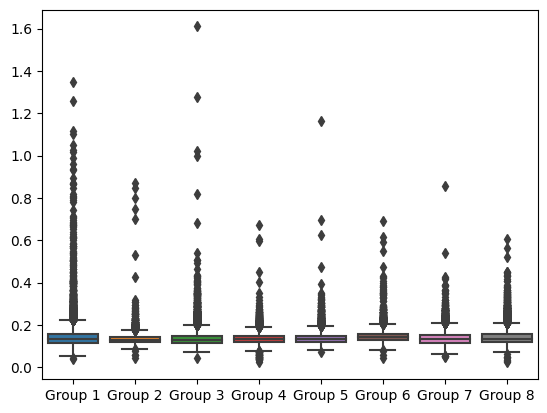

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Group 1': result_dataframes[0]['speed'],
    'Group 2': result_dataframes[1]['speed'],
    'Group 3': result_dataframes[2]['speed'],
    'Group 4': result_dataframes[3]['speed'],
    'Group 5': result_dataframes[4]['speed'],
    'Group 6': result_dataframes[5]['speed'],
    'Group 7': result_dataframes[6]['speed'],
    'Group 8': result_dataframes[7]['speed']
})

# 상자 그림으로 시각화
sns.boxplot(data=df)
plt.show()